# Context of the model : Proactive detection of fraud

This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns. Candidates can use whatever method they wish to develop their machine learning model. Following usual model development procedures, the model would be estimated on the calibration data and tested on the validation data. This case requires both statistical analysis and creativity/judgment. We recommend you spend time on both fine-tuning and interpreting the results of your machine learning model




step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('C:/Users/Sameer/Desktop/Fraud.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
print("Number of Rows: ", data.shape[0])
print("Number of Columns: ", data.shape[1])

Number of Rows:  6362620
Number of Columns:  11


In [5]:
# Info regarding the Columns
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [6]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
columns=data.columns

In [8]:
# Checking the Null values in the dataset
print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


<AxesSubplot:>

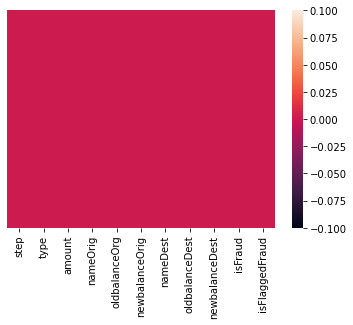

In [9]:
# Checking the Null values in the dataset through heatmap, as it shows there is no Null values therefore we'll move forward
sns.heatmap(data.isnull(), yticklabels=False)

Text(0, 0.5, 'Values')

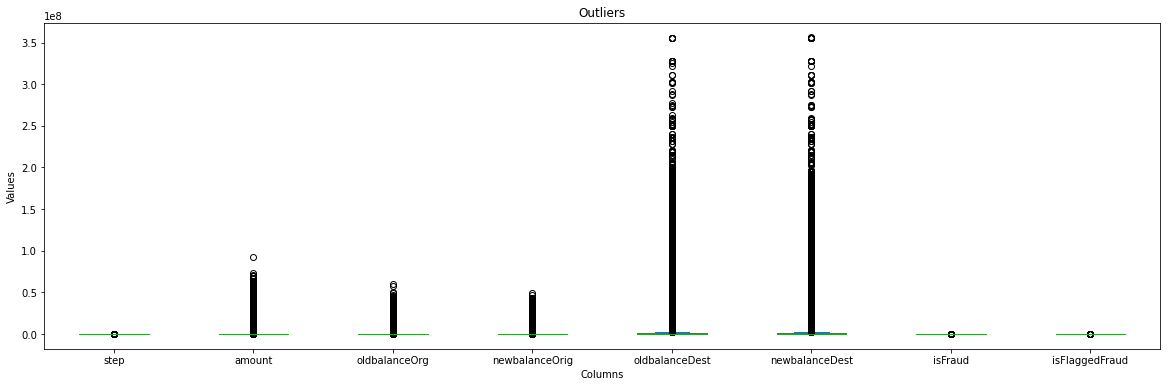

In [10]:
# Checking the Outliers in the dataset
fig, ax = plt.subplots(figsize=(20, 6))
outliers=data[columns].plot(kind='box',ax=ax)
ax.set_title('Outliers')
ax.set_xlabel('Columns')
ax.set_ylabel('Values')


In [11]:
# As in the above outliers are present therefore we'll use 'Quantile' function in pandas 
# that can be used to remove outliers based on percentiles.
lower_quantile = 0.05
upper_quantile = 0.95
data_no_outliers = data[(data[columns] > data[columns].quantile(lower_quantile)) &
                           (data[columns] < data[columns].quantile(upper_quantile))]



C:\Users\Sameer\AppData\Local\Temp\ipykernel_2924\1447883134.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data_no_outliers = data[(data[columns] > data[columns].quantile(lower_quantile)) &
C:\Users\Sameer\AppData\Local\Temp\ipykernel_2924\1447883134.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (data[columns] < data[columns].quantile(upper_quantile))]


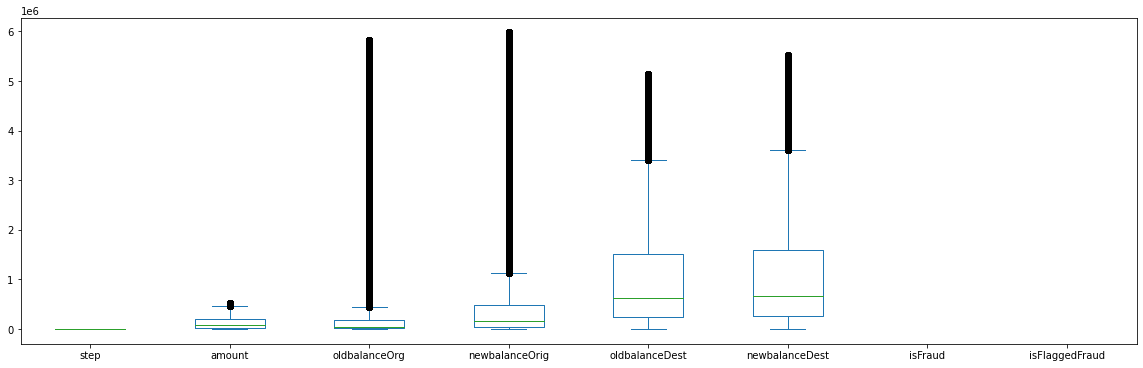

In [12]:
# The outliers are removed in the datset as we can see in the plot gragh 
fig, ax = plt.subplots(figsize=(20, 6))
outliers=data_no_outliers[columns].plot(kind='box',ax=ax)


In [13]:
corr_matrix = data.corr()

In [14]:
# Checking the collinearity in the dataset
print(corr_matrix)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   
isFlaggedFraud  0.003277  0.012295       0.003835        0.003776   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
step                  0.027665        0.025888  0.031578        0.003277  
amount                0.294137        0.459304  0.076688        0.012295  
oldbalanceOrg         0.066243        0.042029  0.010154        0.003835  
newbalanceOrig        0.067812        0.041837 -0.008148        0.003776  
old

In [15]:
# Here we can mitigate the collinearity by checking whether the has been effectively 
# reduced by analyzing the variance inflation factor (VIF) 
threshold = 0.8
corr_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            corr_vars.add(colname)



# Describe your fraud detection model in elaboration

In [16]:
data.type.value_counts()


CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [17]:
data.isFraud.value_counts()


0    6354407
1       8213
Name: isFraud, dtype: int64

In [18]:
data.isFlaggedFraud.value_counts()


0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [19]:
dfisFraud = data.loc[data.isFraud == 1]
dfisFraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [20]:
dataflagfraud= data.loc[data.isFlaggedFraud == 1]
dataflagfraud.head(10)



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [21]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='type', ylabel='count'>

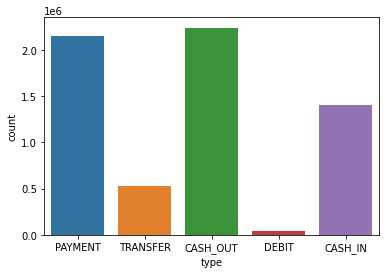

In [22]:
sns.countplot(data.type)

# EDA

In [23]:
from pandas_profiling import ProfileReport

C:\Users\Sameer\AppData\Local\Temp\ipykernel_2924\2274191625.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [24]:
profile = ProfileReport(data,title="Pandas Profiling Report", minimal=True)
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
data.describe(include=['object'])


,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [26]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data.type=label.fit_transform(data.type)
data.nameOrig=label.fit_transform(data.nameOrig)
data.nameDest=label.fit_transform(data.nameDest)

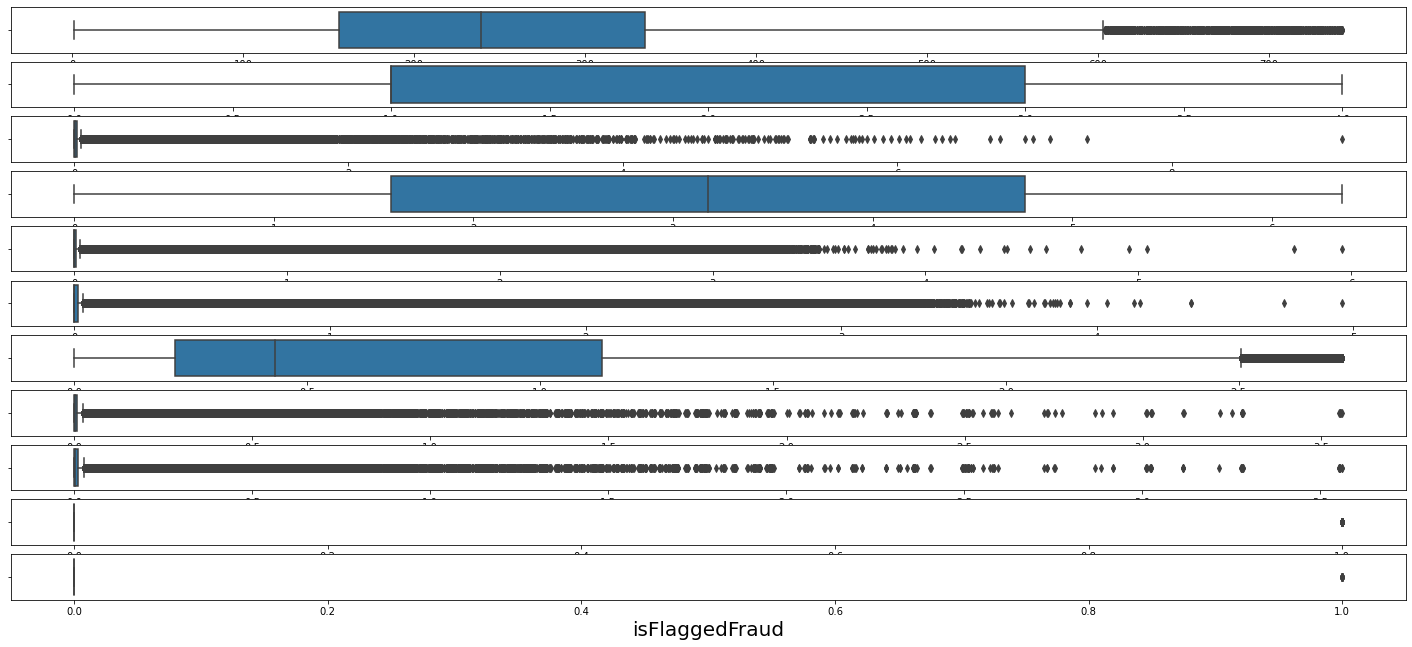

In [27]:
box=data[['step', 'type', 'amount', 'nameOrig', 
          'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']]
plt.figure(figsize=(25,25), facecolor='white')
plotnumber = 1

for column in box:
    if plotnumber<=25 :     
        ax = plt.subplot(25,1,plotnumber)
        sns.boxplot(x=box[column])
        plt.xlabel(column,fontsize=20)
        
    plotnumber+=1
plt.show()

In [28]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


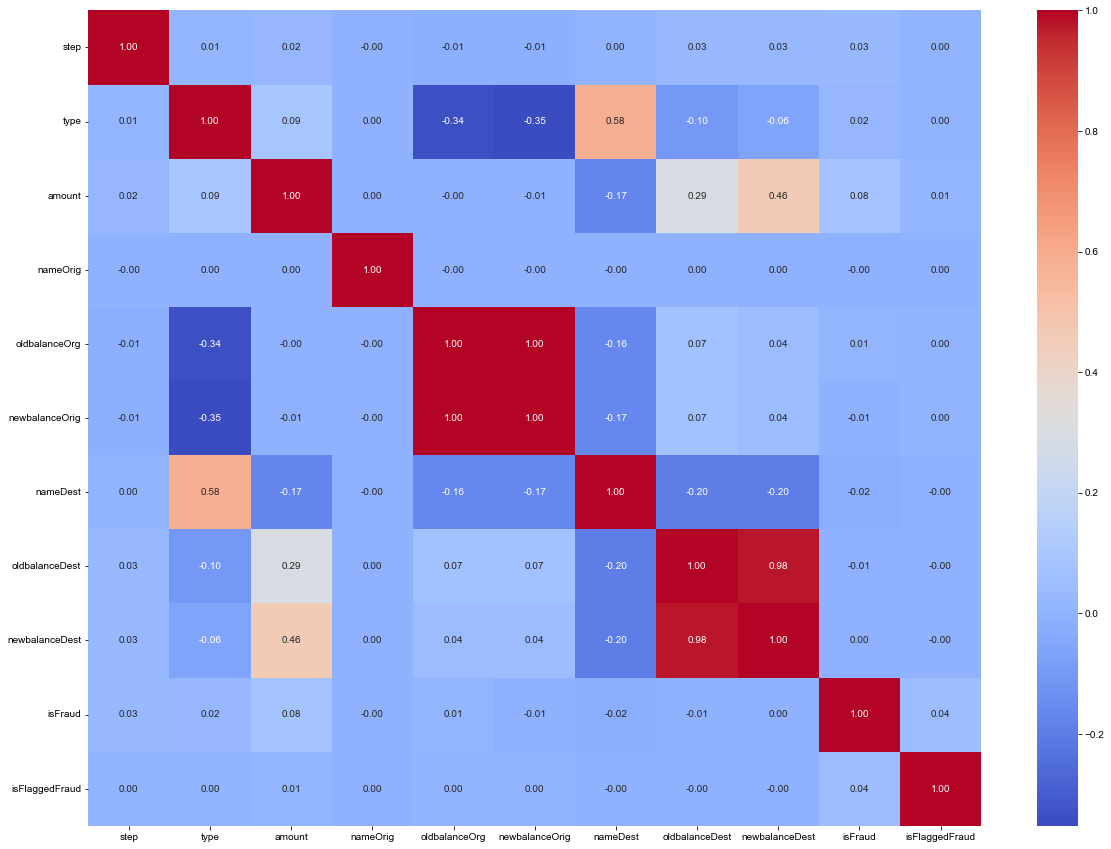

In [29]:
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
sns.set(font_scale=3)
plt.show()

In [30]:
print(corr_vars)

{'newbalanceOrig', 'newbalanceDest'}


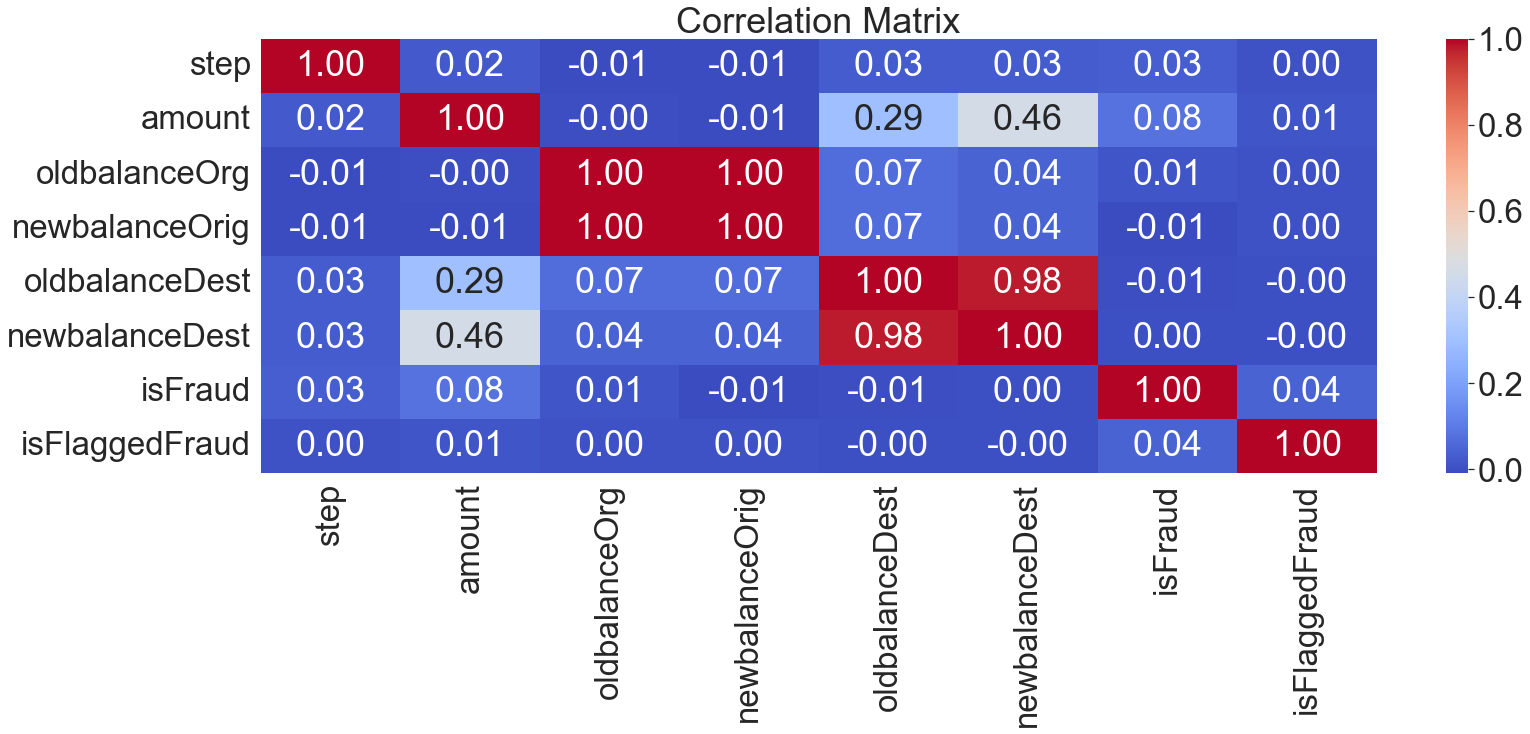

In [31]:
# correlation matrix
plt.figure(figsize=(25, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [32]:
## displays the correlated data 
corr_matrix = data.corr()
corr_matrix["isFlaggedFraud"].sort_values(ascending=False)

isFlaggedFraud    1.000000
isFraud           0.044109
amount            0.012295
oldbalanceOrg     0.003835
newbalanceOrig    0.003776
step              0.003277
type              0.002685
nameOrig          0.000667
oldbalanceDest   -0.000513
newbalanceDest   -0.000529
nameDest         -0.001122
Name: isFlaggedFraud, dtype: float64

In [33]:
# creating independent and dependent variables X & y
# Splitting the data into test and train for calculating accuracy


In [34]:
X = data.loc[:,['isFraud','amount','oldbalanceOrg','newbalanceOrig','step','type','nameOrig']]
y = data.isFlaggedFraud

In [35]:
X.head()

,isFraud,amount,oldbalanceOrg,newbalanceOrig,step,type,nameOrig
0,0,9839.64,170136.0,160296.36,1,3,757869
1,0,1864.28,21249.0,19384.72,1,3,2188998
2,1,181.00,181.0,0.00,1,4,1002156
3,1,181.00,181.0,0.00,1,1,5828262
4,0,11668.14,41554.0,29885.86,1,3,3445981


In [36]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: isFlaggedFraud, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [38]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4453834, 7), (1908786, 7), (4453834,), (1908786,))

isFraud
769.7023761366951


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


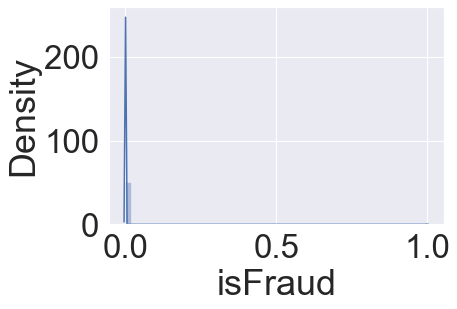

amount
1797.9552914598337


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


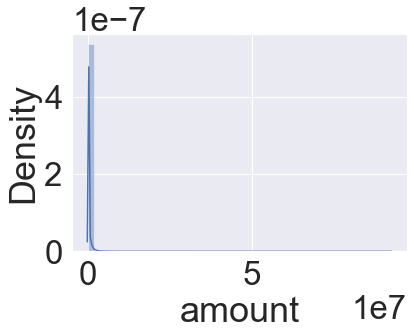

oldbalanceOrg
32.9648516960387


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


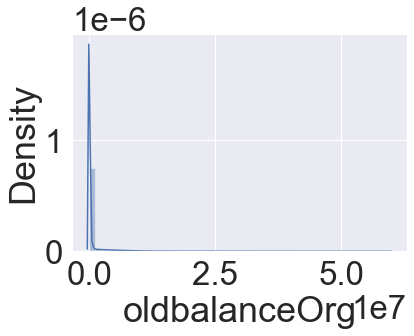

newbalanceOrig
32.06695841776864


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


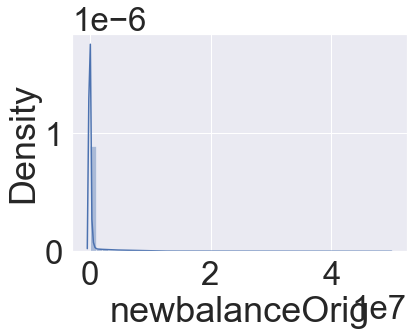

step
0.3290693534211582


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


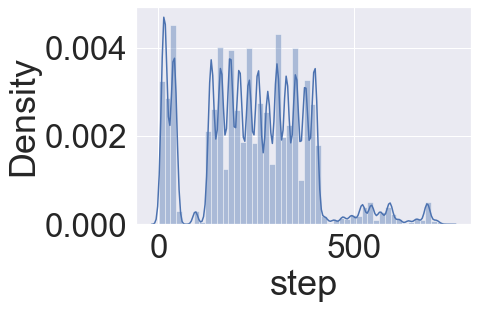

type
-1.4345763413580779


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


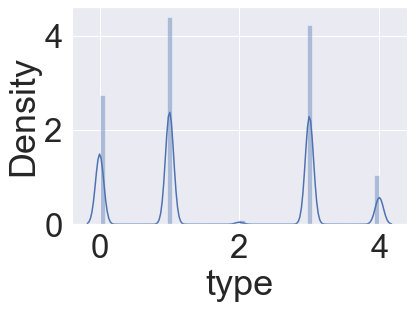

nameOrig
-1.2000279621839782


C:\Users\Sameer\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


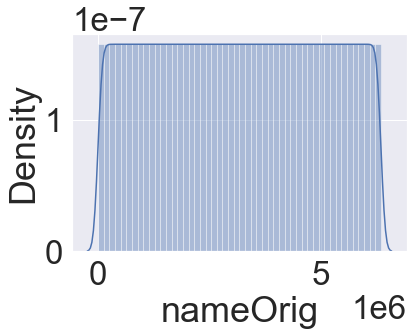

In [39]:
for col in X_train:
    print(col)
    print(kurtosis(data[col]))
    
    plt.figure()
    sns.distplot(data[col])
    plt.show()

In [40]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Decision Tree

For this model the Decision Tree is best for the prediction, as it hanldes the non-linearity of the features,and  imbalanced data.

In [41]:
dtree=DecisionTreeRegressor(max_depth=25)
dtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=25)

In [42]:
dtree.score(X_train, y_train)

1.0

In [43]:
dtree.score(X_test, y_test)

0.7142846664954787

In [44]:
p_test = dtree.predict(X_test)

In [45]:
def mae(p, t):
    return np.sum(np.abs(p - t)) / len(p)

In [46]:
mae(p_test, y_test)

1.0477863940745583e-06

In [47]:
def print_score(mm):
    print("train r^2 " + str(mm.score(X_train, y_train)))
    print("validation r^2 " + str(mm.score(X_test, y_test)))
    p_test = mm.predict(X_test)
    p_train = mm.predict(X_train)
    print("mean absolute error(Train): " + str(mae(p_train, y_train)))
    print("mean absolute error(Validation): " + str(mae(p_test, y_test)))
print_score(dtree)

train r^2 1.0
validation r^2 0.7142846664954787
mean absolute error(Train): 0.0
mean absolute error(Validation): 1.0477863940745583e-06


In [48]:
p_test = dtree.predict(X_test)

In [49]:
p_test

array([0., 0., 0., ..., 0., 0., 0.])

# Demonstrate the performance of the model by using best set of tools

In [50]:
accuracy = accuracy_score(y_test, p_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [51]:
conf_matrix = confusion_matrix(y_test, p_test)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1908779       0]
 [      2       5]]


In [52]:
classification_rep = classification_report(y_test, p_test)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1908779
           1       1.00      0.71      0.83         7

    accuracy                           1.00   1908786
   macro avg       1.00      0.86      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



# How did you select variables to be included in the model?

As we can see in the above by checking correlation between the target variable with remaining variable, and with this we can eliminate the useless variables if needed. 

# What are the key factors that predict fraudulent customer?

Key factors that predict the fraudulent customer in the datset are "isFraud" and "amount"

# Do these factors make sense? If yes, How? If not, How not?

Yes,they do make sense,if the "amount" is more we can assume it may be Fraud and if "isfraud" is 1, the chances of its "isFlaggedFraud" is more. Therfore this helps for the training of the model and give the accurate outcome.

# What kind of prevention should be adopted while company update its infrastructure?

We can prevent the threat by setting the limit to amount of the transaction of the each customer, if they need to extend the limit of the amount, they should contact the company to verify themselves.

# Assuming these actions have been implemented, how would you determine if they work?

If these actions are implemented, we can check the number of of the requests for exceeding the transaction amount, if the number of requests are from a single customer is found then that can be raised as the flagg for the fraud.